# Exploration des données

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
def load_data():
    X = pd.read_csv("data/input_training.csv", index_col=0)
    y = pd.read_csv("data/output_training_gmEd6Zt.csv", index_col=0)
    return X, y

X, y = load_data()
X.head()

,day,equity,r0,r1,r2,r3,r4,r5,r6,r7,...,r43,r44,r45,r46,r47,r48,r49,r50,r51,r52
ID,,,,,,,,,,,,,,,,,,,,,
0,249,1488,0.00,NaN,NaN,NaN,0.00,NaN,NaN,-68.03,...,0.00,0.00,NaN,0.00,NaN,0.00,NaN,NaN,NaN,0.00
1,272,107,-9.76,0.00,-12.21,46.44,34.08,0.00,41.24,12.08,...,-4.83,-16.92,-4.84,4.84,0.00,7.26,-9.68,-19.38,9.71,26.68
2,323,1063,49.85,0.00,0.00,-26.64,-23.66,-22.14,49.12,53.61,...,-6.37,1.59,6.37,-49.32,-9.59,-6.40,22.41,-6.39,7.99,15.96
3,302,513,0.00,NaN,0.00,0.00,0.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN
4,123,1465,-123.84,-115.18,-26.44,0.00,42.42,10.56,0.00,-47.57,...,-5.36,-21.44,-21.48,10.78,-21.55,-5.40,-10.81,5.41,-32.47,43.43


In [3]:
y.head()

,reod
ID,
0,0
1,0
2,-1
3,0
4,-1


In [4]:
X.isna().sum(axis=1).agg(["mean", "std", "max"])

mean     5.707015
std     12.213529
max     53.000000
dtype: float64

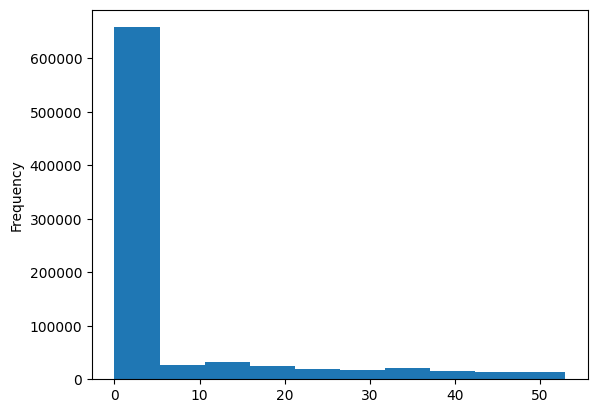

In [5]:
X.isna().sum(axis=1).plot.hist();

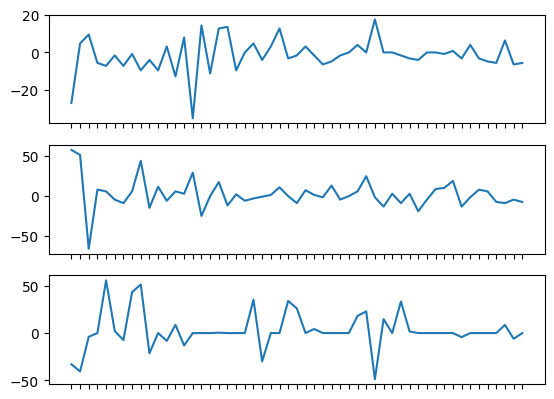

In [6]:
fig, axes = plt.subplots(3, 1)
for ax, i in zip(axes, [5, 10, 15]):
    ax.plot(X.iloc[i].drop(["day", "equity"]))
    ax.set_xticklabels([])
plt.savefig("images/obs.png")

In [7]:
columns = X.columns.to_list()[2:9]
X[columns].agg(["mean", "min", "max", "std"])

,r0,r1,r2,r3,r4,r5,r6
mean,1.839875e+03,1.935344e+02,7.011399e+01,1.956448e+01,-0.215511,0.283935,-0.313301
min,-9.967670e+03,-9.973540e+03,-4.823740e+03,-1.949690e+03,-1390.130000,-1632.290000,-1559.320000
max,4.310700e+08,7.516000e+07,4.789000e+07,1.545000e+07,2327.870000,2396.690000,2343.750000
std,6.097548e+05,1.153271e+05,5.588823e+04,1.785055e+04,44.724646,41.548517,40.706372


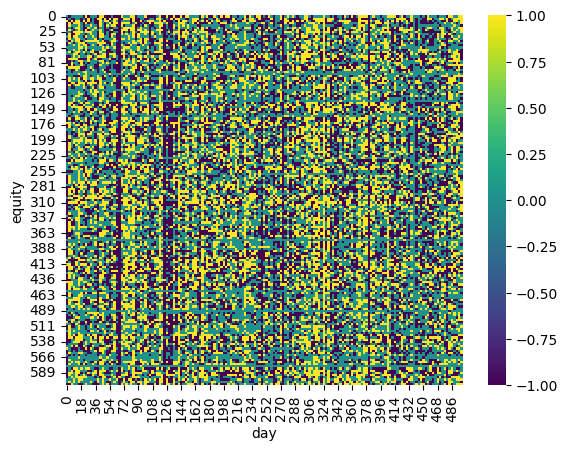

In [8]:
heatmap_data = X.merge(y, on="ID").pivot_table(
    index="equity", columns="day", values="reod"
).dropna()
sns.heatmap(
    heatmap_data.iloc[0:500:3, 0:500:3],
    cmap=plt.cm.viridis
)
plt.savefig("images/heatmap.png")

# Préparation

In [9]:
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.2)
X1.shape, X2.shape

((674639, 55), (168660, 55))

In [10]:
pipe = make_pipeline(
    SimpleImputer(),
    StandardScaler()
)

def clean_targets(targets):
    return targets.reod.replace(-1, 2).values

X_train = pipe.fit_transform(X1)
X_val = pipe.transform(X2)
y_train = clean_targets(y1)
y_val = clean_targets(y2)

X_train

array([[-3.02441113e-01,  5.39367323e-01, -2.74651724e-03, ...,
        -1.05217924e-02,  2.95994384e-01,  2.21961926e-04],
       [-3.16206752e-01,  1.70903250e-01, -2.73577845e-03, ...,
        -1.05217924e-02, -5.27432158e-03,  1.11006094e-18],
       [ 6.23483230e-02, -5.86917188e-01, -2.66982425e-03, ...,
        -1.34739263e+00,  1.85581769e-01,  1.11006094e-18],
       ...,
       [-1.05266844e+00, -1.16620349e+00, -2.74651724e-03, ...,
         0.00000000e+00, -5.27432158e-03,  2.21961926e-04],
       [ 9.98411780e-01, -1.42640750e+00, -2.80903927e-03, ...,
        -4.25722008e-01,  3.05458322e-01,  2.10324618e-01],
       [ 1.22554483e+00,  1.05787604e+00, -2.61958017e-03, ...,
        -1.05217924e-02, -3.50708073e-01,  2.21961926e-04]])

In [11]:
y_train

array([1, 0, 2, ..., 1, 2, 0], dtype=int64)

# Forêts aléatoires

In [12]:
forest = RandomForestClassifier(
    n_estimators=10,
    max_depth=10
)

forest.fit(X_train, y_train);

In [13]:
forest.score(X_train, y_train)

0.5014948735545973

In [14]:
forest.score(X_val, y_val)

0.4715225898256848

In [15]:
preds = forest.predict(X_val)
preds[:10]

array([0, 2, 0, 0, 0, 2, 0, 0, 0, 0], dtype=int64)

# Réseaux de neurones

In [16]:
def build_model():
    model = keras.Sequential([
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(3, activation="softmax")
    ])
    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_model()

In [17]:
num_epochs = 40
history = model.fit(
    X_train,
    y_train,
    epochs=num_epochs,
    batch_size=512,
    validation_data=(X_val, y_val)
)

Epoch 1/40
1318/1318 [==============================] - 8s 5ms/step - loss: 1.0459 - accuracy: 0.4489 - val_loss: 1.1499 - val_accuracy: 0.4615
Epoch 2/40
1318/1318 [==============================] - 7s 5ms/step - loss: 1.0241 - accuracy: 0.4682 - val_loss: 1.0748 - val_accuracy: 0.4706
Epoch 3/40
1318/1318 [==============================] - 7s 5ms/step - loss: 1.0143 - accuracy: 0.4781 - val_loss: 1.0336 - val_accuracy: 0.4767
Epoch 4/40
1318/1318 [==============================] - 7s 5ms/step - loss: 1.0066 - accuracy: 0.4866 - val_loss: 1.0114 - val_accuracy: 0.4775
Epoch 5/40
1318/1318 [==============================] - 7s 5ms/step - loss: 1.0010 - accuracy: 0.4909 - val_loss: 1.0067 - val_accuracy: 0.4813
Epoch 6/40
1318/1318 [==============================] - 7s 5ms/step - loss: 0.9954 - accuracy: 0.4946 - val_loss: 1.0041 - val_accuracy: 0.4810
Epoch 7/40
1318/1318 [==============================] - 7s 5ms/step - loss: 0.9914 - accuracy: 0.4980 - val_loss: 1.0041 - val_accuracy:

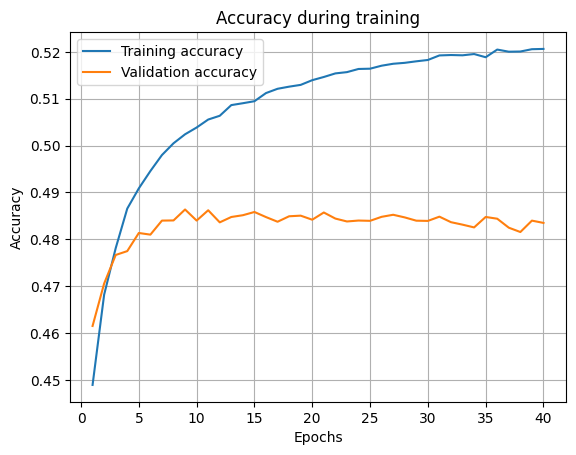

In [18]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, num_epochs + 1)
plt.plot(epochs, accuracy, label="Training accuracy")
plt.plot(epochs, val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.title("Accuracy during training")
plt.savefig("images/accuracy.png")

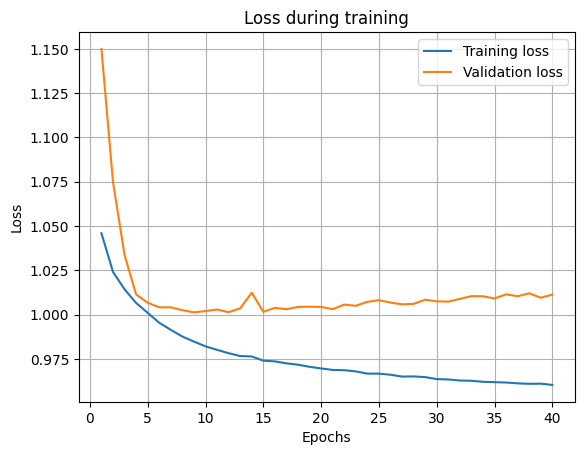

In [19]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, num_epochs + 1)
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.title("Loss during training")
plt.savefig("images/loss.png")

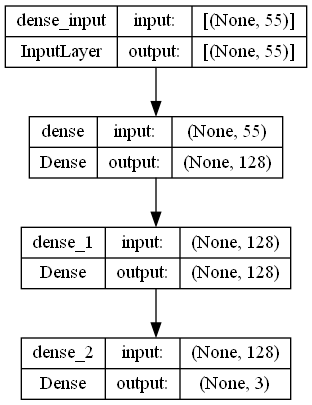

In [20]:
keras.utils.plot_model(model, to_file="images/model.png", show_shapes=True)

In [21]:
X_full = pipe.transform(X)
y_full = clean_targets(y)

model = build_model()

callbacks=[keras.callbacks.EarlyStopping(patience=5)]
history = model.fit(
    X_full,
    y_full,
    epochs=num_epochs,
    batch_size=512,
    callbacks=callbacks,
    validation_split=0.2
)

Epoch 1/40
1318/1318 [==============================] - 7s 5ms/step - loss: 1.0666 - accuracy: 0.4488 - val_loss: 1.0299 - val_accuracy: 0.4578
Epoch 2/40
1318/1318 [==============================] - 6s 5ms/step - loss: 1.0375 - accuracy: 0.4697 - val_loss: 1.0166 - val_accuracy: 0.4717
Epoch 3/40
1318/1318 [==============================] - 6s 5ms/step - loss: 1.0276 - accuracy: 0.4811 - val_loss: 1.0095 - val_accuracy: 0.4787
Epoch 4/40
1318/1318 [==============================] - 6s 5ms/step - loss: 1.0069 - accuracy: 0.4886 - val_loss: 1.0057 - val_accuracy: 0.4818
Epoch 5/40
1318/1318 [==============================] - 6s 5ms/step - loss: 0.9973 - accuracy: 0.4933 - val_loss: 1.0024 - val_accuracy: 0.4837
Epoch 6/40
1318/1318 [==============================] - 6s 5ms/step - loss: 0.9925 - accuracy: 0.4963 - val_loss: 1.0003 - val_accuracy: 0.4854
Epoch 7/40
1318/1318 [==============================] - 6s 5ms/step - loss: 0.9895 - accuracy: 0.4993 - val_loss: 1.0012 - val_accuracy:

In [22]:
model.save("models/dense.keras")

In [23]:
model.evaluate(X_val, y_val)

5271/5271 [==============================] - 13s 2ms/step - loss: 0.9713 - accuracy: 0.5124


[0.9712949395179749, 0.512403666973114]

In [24]:
preds = model.predict(X_val)
preds

5271/5271 [==============================] - 7s 1ms/step


array([[0.48810178, 0.33570474, 0.17619352],
       [0.1670758 , 0.46975055, 0.36317366],
       [0.42011872, 0.29815426, 0.28172702],
       ...,
       [0.3396749 , 0.36483178, 0.2954933 ],
       [0.48993692, 0.29456273, 0.21550028],
       [0.36603862, 0.3575334 , 0.27642795]], dtype=float32)

In [25]:
preds.argmax(axis=1)

array([0, 1, 0, ..., 1, 0, 0], dtype=int64)

# Gradient boosted trees

In [26]:
bst = XGBClassifier(
    n_estimators=10,
    max_depth=10,
    learning_rate=1,
    objective="multi:softmax",
    num_class=3
)

bst.fit(X_train, y_train);

In [27]:
bst.score(X_train, y_train)

0.6187146014386954

In [28]:
bst.score(X_val, y_val)

0.5307482509190087

In [29]:
preds = bst.predict(X_val)
preds[:10]

array([0, 2, 0, 0, 2, 2, 0, 0, 0, 0])